## NeuroML simulation data

In [13]:
import pandas as pd
from pyneuroml import pynml

def run_simulation_and_get_results(lems_file):
    # Run the simulation with pyNeuroML
    print(f"Running simulation: {lems_file}")
    results = pynml.run_lems_with_jneuroml(
        lems_file, 
        max_memory="1024M", 
        nogui=True, 
        plot=False, 
        load_saved_data=True
    )

    # Extract time and variable values
    time = results["t"]
    voltage_data = {}
    for key in results:
        if key.startswith("pop_RMD") and key.endswith("/v"):  # Filter voltage keys
            compartment = key.split("/")[1]  # Extract compartment index
            voltage_data[f"Run {compartment}"] = results[key]
    
    # Create DataFrame
    df = pd.DataFrame(voltage_data)
    df.insert(0, "Time (ms)", time)  # Add time as the first column
    return df



lems_file = "../NeuroML2/LEMS_Sim_Fig7B_RMD.xml"
rmd_nml_df = run_simulation_and_get_results(lems_file)
rmd_nml_df = rmd_nml_df * 1000 # Convert voltage from V to mV and time from s to ms

pyNeuroML >>> INFO - Loading LEMS file: ../NeuroML2/LEMS_Sim_Fig7B_RMD.xml and running with jNeuroML
pyNeuroML >>> INFO - Executing: (java -Xmx1024M  -Djava.awt.headless=true -jar  "/Users/dakosh/mambaforge/lib/python3.10/site-packages/pyneuroml/utils/./../lib/jNeuroML-0.13.3-jar-with-dependencies.jar"  ../NeuroML2/LEMS_Sim_Fig7B_RMD.xml  -nogui -I '') in directory: .


Running simulation: ../NeuroML2/LEMS_Sim_Fig7B_RMD.xml


pyNeuroML >>> INFO - Command completed successfully!


In [6]:
rmd_nml_df.head(5)

,Time (ms),Run 0,Run 1,Run 2,Run 3
0,0.000,-69.44500,-69.44500,-69.44500,-69.44500
1,0.025,-69.44539,-69.44539,-69.44539,-69.44539
2,0.050,-69.44577,-69.44577,-69.44577,-69.44577
3,0.075,-69.44614,-69.44614,-69.44614,-69.44614
4,0.100,-69.44651,-69.44651,-69.44651,-69.44651


### Importing template RMD cell model and defining what parameters to change: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting up XPPaut interpreter
os.environ["XPP_HOME"] = "/usr/local/bin"

# Path to edited RMD.ode file
ode_file_path = "RMD_edited.ode"

# Range of current clamp values for RMD cell model
iclamp_values = [-2, 2, 6, 10]

# Directory for temporary files
TEMP_DIR = "rmd_temp"
os.makedirs(TEMP_DIR, exist_ok=True)

# Store traces for plotting
rmd_traces = []









### Reading and running .ode files


In [10]:
# Reading the RMD file as a template
with open(ode_file_path, "r") as f:
    ode_template = f.read()

# Looping through current clamp values: 
for iclamp in iclamp_values:
    print(f"Running simulation for iclamp={iclamp}...")

    # Replacing the iclamp value in the template for each iteration
    updated_ode = ode_template.replace("par iclamp=10", f"par iclamp= {iclamp}")

    # Generating temporary .ode file
    temp_ode_file = os.path.join(TEMP_DIR, f"temp_{iclamp}.ode")
    with open(temp_ode_file, "w") as f:
        f.write(updated_ode)

    # Running XPPaut command silently 
    cmd = f"xppaut -silent {temp_ode_file} > /dev/null 2>&1"
    exit_code = os.system(cmd)
    if exit_code != 0:
        print(f"XPPaut command failed for iclamp={iclamp}. Command: {cmd}")
        break

   
    # Checking if output.dat was generated
    output_file = "output.dat"  # This is a default output from XPPaut
    if not os.path.exists(output_file):
        print(f"No output.dat file generated for iclamp={iclamp}. Check .ode file and XPPaut setup.")
        break


    # Parsing the output.dat file
    try:
        data = np.loadtxt(output_file)  # Loading the file as a 2D array
        time = data[:, 0] # this is the time column 
        voltage = data[:, 22 ]  # 22 is the voltage column for RMD model
        rmd_traces.append((time, voltage))
        print(f"Successfully extracted data for iclamp={iclamp}")
    except Exception as e:
        print(f"Error reading output.dat for iclamp={iclamp}: {e}")
        break


Running simulation for iclamp=-2...
Successfully extracted data for iclamp=-2
Running simulation for iclamp=2...
Successfully extracted data for iclamp=2
Running simulation for iclamp=6...
Successfully extracted data for iclamp=6
Running simulation for iclamp=10...
Successfully extracted data for iclamp=10


### Plotting the results of current clamp simulations: 

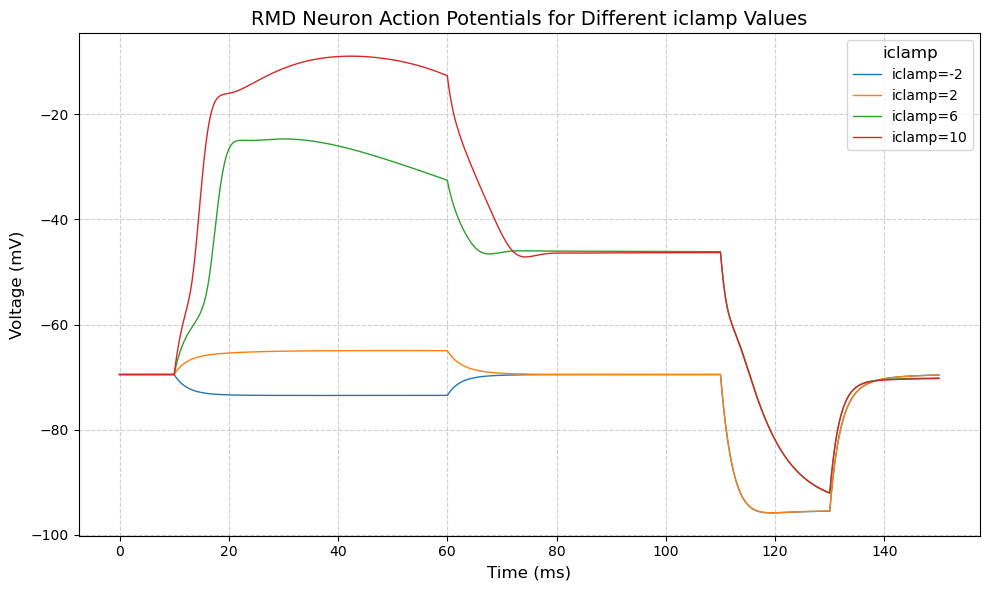

In [16]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 6))


for i, (time, voltage) in enumerate(rmd_traces):
    ax.plot(
        time, 
        voltage, 
        label=f"iclamp={iclamp_values[i]}",  # Label for the legend
        linewidth=1
    )


ax.set_title("RMD Neuron Action Potentials for Different iclamp Values", fontsize=14)
ax.set_xlabel("Time (ms)", fontsize=12)
ax.set_ylabel("Voltage (mV)", fontsize=12)


ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="iclamp", fontsize=10, title_fontsize=12, loc="best")


plt.tight_layout()
plt.show()



### XPP against NML plots: 

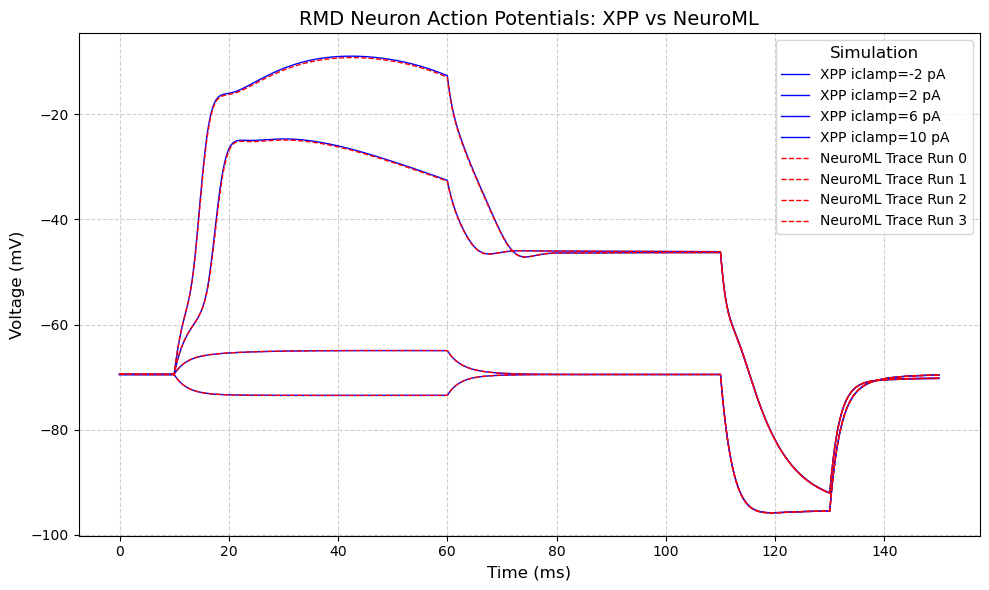

In [15]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot XPP traces
for i, (time, voltage) in enumerate(rmd_traces):
    ax.plot(
        time, 
        voltage, 
        label=f"XPP iclamp={iclamp_values[i]} pA",  # Label for the legend
        color='blue', 
        linewidth=1
    )

# Plot NeuroML data
nml_time = rmd_nml_df.iloc[:, 0]  # Time column
for col in rmd_nml_df.columns[1:]:  # Loop through voltage columns
    ax.plot(
        nml_time, 
        rmd_nml_df[col], 
        label=f"NeuroML Trace {col}",  
        color='red', 
        linestyle='--', 
        linewidth=1
    )


ax.set_title("RMD Neuron Action Potentials: XPP vs NeuroML", fontsize=14)
ax.set_xlabel("Time (ms)", fontsize=12)
ax.set_ylabel("Voltage (mV)", fontsize=12)


ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title="Simulation", fontsize=10, title_fontsize=12, loc="best")


plt.tight_layout()
plt.show()

